In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


import json
import ast

from typing import List, Tuple, Union

from catboost import CatBoostClassifier

# Предсказание пола пользователей
    

In [2]:
path_to_data = r'./data/'

In [3]:
train_labels = pd.read_csv(path_to_data + "train_labels.csv", sep=';')
train = pd.read_csv(path_to_data + "train.csv", sep=';')
referer_vectors = pd.read_csv(path_to_data + "referer_vectors.csv", sep=';')
geo_info = pd.read_csv(path_to_data + 'geo_info.csv', sep=';')
test = pd.read_csv(path_to_data + 'test.csv', sep=';')

# train_labels

<Axes: xlabel='target', ylabel='proportion'>

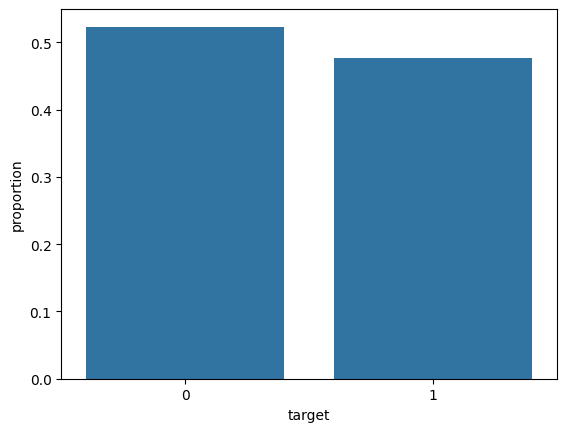

In [4]:
sns.barplot(
    train_labels['target'].value_counts(normalize=True)
)

In [5]:
train_labels['user_id'].nunique(), train_labels.shape

(500000, (500000, 2))

# train

In [6]:
train.head()

,request_ts,user_id,referer,geo_id,user_agent
0,1701011363,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799,"{'browser': 'Chrome Mobile', 'browser_version'..."
1,1700986581,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257,"{'browser': 'Chrome Mobile', 'browser_version'..."
2,1701011071,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150,"{'browser': 'Yandex Browser', 'browser_version..."
3,1700992803,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740,"{'browser': 'Chrome Mobile', 'browser_version'..."
4,1701021666,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863,"{'browser': 'Yandex Browser', 'browser_version..."


In [7]:
train['event_datetime'] = pd.to_datetime(train['request_ts'], unit='s')

In [8]:
train['user_id'].nunique()

655672

In [9]:
users_with_label = set(train_labels['user_id'].values)

unknown_users_mask = ~train['user_id'].isin(users_with_label)

In [10]:
unknown_users_data = train[unknown_users_mask].copy()
labeled_train = train[~unknown_users_mask].copy()
n_unknown_users = unknown_users_data['user_id'].nunique()

print(f'Нет разметки для {n_unknown_users} пользователей')


Нет разметки для 155672 пользователей


In [11]:
n_unknown_users / train['user_id'].nunique()

0.23742358984370235

count    655672.000000
mean          1.143865
std           0.414615
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: count, dtype: float64

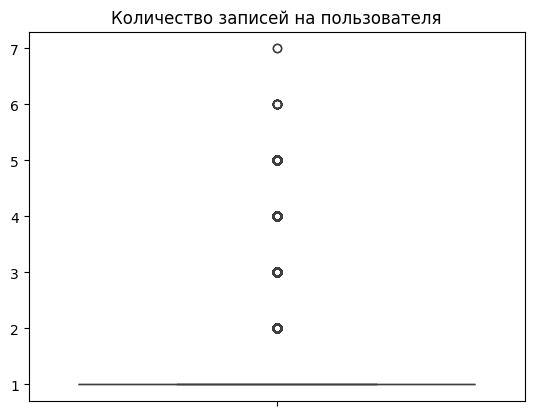

In [12]:
sns.boxplot(
    train['user_id'].value_counts().values
).set_title('Количество записей на пользователя')
train['user_id'].value_counts().describe()

In [13]:
user_vc = train['user_id'].value_counts()
user_vc[user_vc > 1]

user_id
07bbc8de94ab7e98325986869cc193c8    7
468df2b66e13dfa52192cfef2e961880    7
9c5caf43abde0d08e13ec53be6ac7f43    6
535708105da0f22a38f3c72efc7a2c53    6
b4f31612e14086874aadcbf6eb00ea2e    6
                                   ..
75b74180b8dc181d3ce057c16e446507    2
23f6492ee18f3fff527dd7c5997caa40    2
c8817b926c65dc019b032e958cf7ddcb    2
3eab1762d180e7833dd05dfc1d7fedfd    2
faf55046685319500853f305bccaf113    2
Name: count, Length: 80412, dtype: int64

In [14]:
train[train['user_id'] == '535708105da0f22a38f3c72efc7a2c53']

,request_ts,user_id,referer,geo_id,user_agent,event_datetime
28687,1700947500,535708105da0f22a38f3c72efc7a2c53,https://7a4c700/17846d28,3663,"{'browser': 'Chrome Mobile', 'browser_version'...",2023-11-25 21:25:00
73318,1700947400,535708105da0f22a38f3c72efc7a2c53,https://7a4c700/1734cfc5,3663,"{'browser': 'Chrome Mobile', 'browser_version'...",2023-11-25 21:23:20
173282,1700947510,535708105da0f22a38f3c72efc7a2c53,https://7a4c700/17846d28,3663,"{'browser': 'Chrome Mobile', 'browser_version'...",2023-11-25 21:25:10
173290,1700947394,535708105da0f22a38f3c72efc7a2c53,https://7a4c700/17846d28,3663,"{'browser': 'Chrome Mobile', 'browser_version'...",2023-11-25 21:23:14
266010,1700947481,535708105da0f22a38f3c72efc7a2c53,https://7a4c700/17846d28,3663,"{'browser': 'Chrome Mobile', 'browser_version'...",2023-11-25 21:24:41
469348,1700946534,535708105da0f22a38f3c72efc7a2c53,https://abfc768/,3663,"{'browser': 'Chrome Mobile', 'browser_version'...",2023-11-25 21:08:54


Text(0.5, 1.0, "Дубликаты на основе ['user_id', 'referer', 'geo_id', 'user_agent'] колонок")

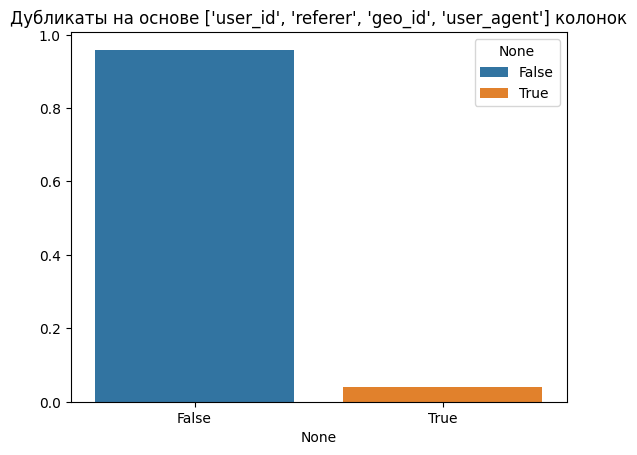

In [15]:
dupl_columns = ['user_id', 'referer', 'geo_id', 'user_agent']
dupl_vc = train[dupl_columns].duplicated().value_counts(normalize=True)
sns.barplot(
    x=dupl_vc.index,
    y=dupl_vc.values,
    hue=dupl_vc.index,
    legend=True,
).set_title(f'Дубликаты на основе {dupl_columns} колонок')

count    161345.000000
mean          4.648424
std         190.476792
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       43960.000000
Name: count, dtype: float64

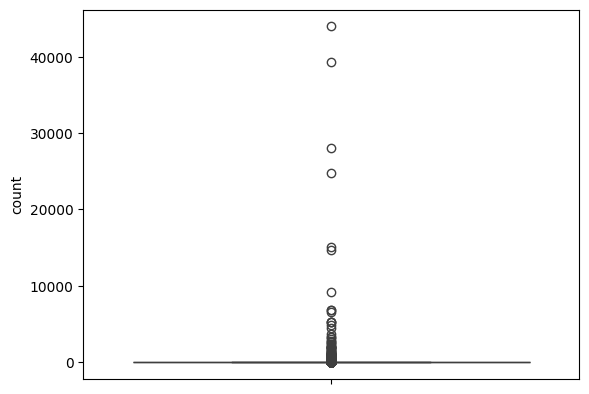

In [16]:
sns.boxplot(
    train['referer'].value_counts()
)
train['referer'].value_counts().describe()

In [17]:
train['geo_id'].value_counts().describe()

count      2962.000000
mean        253.207292
std        2680.318416
min           1.000000
25%           3.000000
50%          10.000000
75%          48.000000
max      122438.000000
Name: count, dtype: float64

In [18]:
train[train['user_agent'].isna()]

,request_ts,user_id,referer,geo_id,user_agent,event_datetime
201961,1700963692,d4f46399f48e08fb34d9d139aee1145c,https://b6630fd/,3871,NaN,2023-11-26 01:54:52


In [19]:
user_agent_nan_mask = train['user_agent'].isna()
train.loc[user_agent_nan_mask, 'user_agent'] = '{}'

In [20]:
train['user_agent'] = train['user_agent'].apply(ast.literal_eval) # можно было бы использовать 
                                                                  # json.loads для ускорения,
                                                                  # но ключи в одинарных кавычках

In [82]:
train['domain'] = train['referer'].str.extract(r'https://([^/]+)')
train['path'] = train['referer'].str.extract(r'https://[^/]+/(.*)')

In [22]:
train['user_agent']

0         {'browser': 'Chrome Mobile', 'browser_version'...
1         {'browser': 'Chrome Mobile', 'browser_version'...
2         {'browser': 'Yandex Browser', 'browser_version...
3         {'browser': 'Chrome Mobile', 'browser_version'...
4         {'browser': 'Yandex Browser', 'browser_version...
                                ...                        
749995    {'browser': 'Opera', 'browser_version': '104.0...
749996    {'browser': 'Yandex Browser', 'browser_version...
749997    {'browser': 'Chrome Mobile', 'browser_version'...
749998    {'browser': 'Chrome', 'browser_version': '118....
749999    {'browser': 'Chrome', 'browser_version': '106....
Name: user_agent, Length: 750000, dtype: object

In [23]:
train['browser'] = train['user_agent'].str.get('browser')
train['browser_version'] = train['user_agent'].str.get('browser_version')
train['os'] = train['user_agent'].str.get('os')
train['os_version'] = train['user_agent'].str.get('os_version')

<Axes: ylabel='None'>

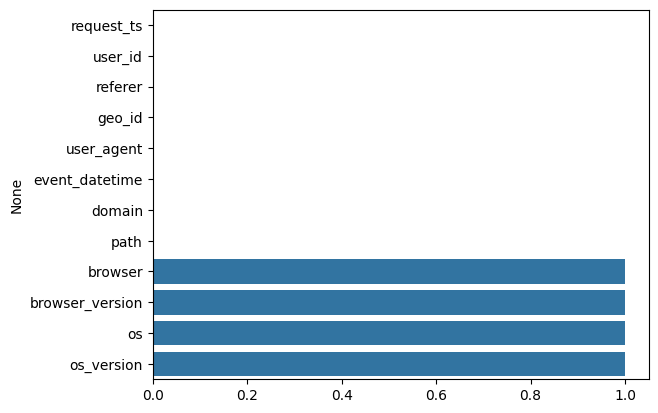

In [24]:
cols_na_vc = train.isna().sum()
sns.barplot(
    y=cols_na_vc.index,
    x=cols_na_vc.values
)

In [25]:
train['browser'].value_counts()

browser
Chrome Mobile                 258726
Chrome                        203850
Yandex Browser                143570
Chrome Mobile WebView          32448
YandexSearch                   25521
Edge                           20811
Opera                          17573
Mobile Safari                  14283
Firefox                         7861
MiuiBrowser                     6116
Samsung Internet                5135
Safari                          3298
Opera Mobile                    2764
Mobile Safari UI/WKWebView      2571
Facebook                        1539
Chrome Mobile iOS               1317
Google                           610
Mail.ru Chromium Browser         448
Instagram                        382
UC Browser                       297
Edge Mobile                      169
Firefox Mobile                   159
Pinterest                         87
Iron                              58
Maxthon                           44
IE                                41
YandexModule2                 

In [26]:
train.groupby('browser')['browser_version'].nunique()

browser
Amazon Silk                     5
Android                         5
Apple Mail                      1
Basilisk                        1
Bot                             1
Bytespider                      1
Chrome                        155
Chrome Mobile                 141
Chrome Mobile WebView          80
Chrome Mobile iOS              53
Chromium                        3
Crosswalk                       1
Dragon                          2
DuckDuckGo Mobile               2
Edge                           50
Edge Mobile                    18
Electron                        2
Facebook                       74
Firefox                        74
Firefox Mobile                 30
Firefox iOS                     4
Flipboard                       9
Flipboard-Briefing              1
Google                        106
HeadlessChrome                  5
IE                              4
IE Mobile                       1
Instagram                      39
Iron                           28
Mail.r

In [27]:
train['os'].value_counts()

os
Android          510152
Windows          205923
iOS               21691
Mac OS X           7318
Linux              3728
Tizen               848
Ubuntu              149
Chrome OS           148
Windows Phone        13
Other                11
FreeBSD               8
Chromecast            7
Fedora                3
Name: count, dtype: int64

In [28]:
train['event_hour'] = train['event_datetime'].dt.hour
train['event_day'] = train['event_datetime'].dt.dayofweek

<Axes: xlabel='count', ylabel='event_hour'>

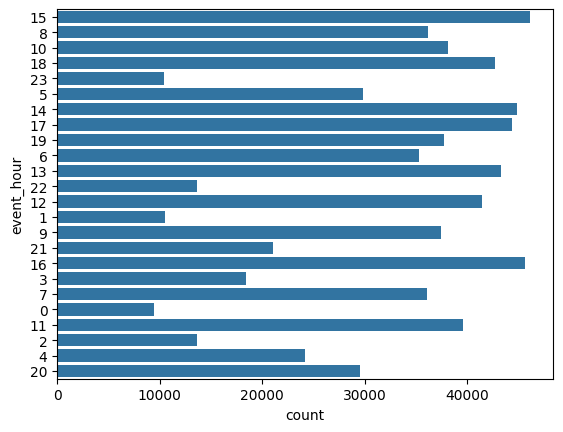

In [29]:
sns.countplot(
    train['event_hour'].astype(str)
)

<Axes: xlabel='count', ylabel='event_day'>

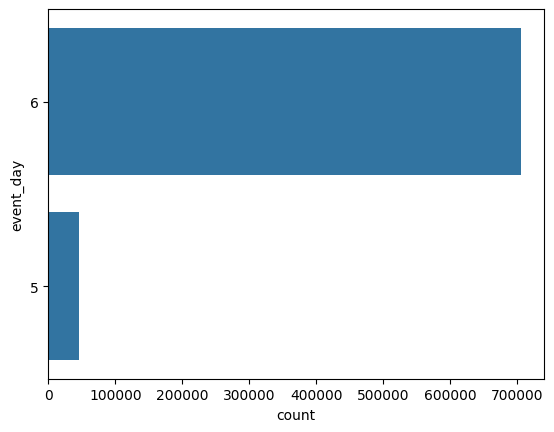

In [30]:
sns.countplot(
    train['event_day'].astype(str)
) # без учета time_zone скорее всего только воскресенье в данных

    Что можно сказать:
    - Есть пользователи без разметки, скорее всего их сессии можно использовать для извлечения дополнительной
        информации на основе остальных таблиц
    - Есть повторные записи, вероятно с небольшой разницей во времени: необходимо предобрабатывать сырые логи,
        удаляя дубликаты, чтобы подготовить чистые данные. В этом наборе таких случаев не много.
    - Для большинства пользователей имеется всего одна сессия
    - Баланс классов практически 50/50
    - Есть эзотерические браузеры (может это сессии из автомобиля или с микроволновки – неизвестно), необходимо
        собрать сет из основных браузеров и несовпадения определять как "Другое", чтобы не падал инференс
    - Тоже самое по ОС
    - Собраны данные только за один день. Сплит будем делать только по user_id без учета времени
    

# referer_vectors

In [31]:
referer_vectors.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,referer
0,16708,-3741,11395,-1597,-3212,6269,5610,-15351,13779,14102,https://a6899a4/15652e67
1,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,https://9b48ee5/
2,10551,2947,12282,-470,16222,4472,-3316,9606,4197,18948,https://7a4c700/161af7e3
3,12816,20498,-10110,7731,-569,12035,3014,6398,11439,-271,https://9653126/159bc361
4,3710,11096,11333,14673,8030,1852,10554,11625,4306,13210,https://72879b4/125c29e6


In [32]:
referer_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   component0  200000 non-null  int64 
 1   component1  200000 non-null  int64 
 2   component2  200000 non-null  int64 
 3   component3  200000 non-null  int64 
 4   component4  200000 non-null  int64 
 5   component5  200000 non-null  int64 
 6   component6  200000 non-null  int64 
 7   component7  200000 non-null  int64 
 8   component8  200000 non-null  int64 
 9   component9  200000 non-null  int64 
 10  referer     200000 non-null  object
dtypes: int64(10), object(1)
memory usage: 16.8+ MB


In [33]:
domain_pattern = r'https://([^/]+)'
path_pattern = r'https://[^/]+/(.*)'

referer_vectors['domain'] = referer_vectors['referer'].str.extract(r'https://([^/]+)')
referer_vectors['path'] = referer_vectors['referer'].str.extract(r'https://[^/]+/(.*)')

In [34]:
referer_vectors_domain_unique = set(referer_vectors['domain'].unique())
referer_vectors_path_unique = set(referer_vectors['path'].unique())


train_domain_unique = set(train['domain'].unique())
train_path_unique = set(train['path'].unique())

In [35]:
len(referer_vectors_domain_unique), len(train_domain_unique)

(5862, 5394)

In [36]:
len(referer_vectors_path_unique), len(train_path_unique)

(191051, 154589)

In [37]:
domain_cross = train_domain_unique.intersection(referer_vectors_domain_unique)
path_cross = train_path_unique.intersection(referer_vectors_path_unique)

domain_pc = len(domain_cross) / len(train_domain_unique)
path_pc = len(path_cross) / len(train_path_unique)

print(f'Есть domain данные {(100 * domain_pc):.2f}%')
print(f'Есть path данные {(100 * path_pc):.2f}%')

Есть domain данные 100.00%
Есть path данные 100.00%


In [38]:
referer_vectors['domain'].value_counts()

domain
6a81948    14412
7e89575    11178
62faeb4    10628
72879b4     8697
b5380d6     8300
           ...  
9ec29ba        1
6a4ffd0        1
865697f        1
6468150        1
8ada946        1
Name: count, Length: 5862, dtype: int64

In [39]:
referer_vectors.groupby('path')['domain'].nunique().head(10).sort_values(ascending=False)

path
            2382
11e1b335       2
11e1b6f8       1
11e1b77e       1
11e1ba3c       1
11e1bc20       1
11e1bc42       1
11e1c1f0       1
11e1c1f3       1
11e1c276       1
Name: domain, dtype: int64

In [40]:
referer_vectors[referer_vectors['path'] == '11e1b335']

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,referer,domain,path
55689,20179,18396,-389,-798,1482,13760,3476,-444,7241,6973,https://a2e88d5/11e1b335,a2e88d5,11e1b335
74851,15223,14913,5437,3990,11632,13991,-1712,1081,9539,9178,https://a5ed9c5/11e1b335,a5ed9c5,11e1b335


In [41]:
mask = referer_vectors['path'] != ''
referer_vectors[~mask].groupby('domain')['path'].nunique().head(10).sort_values(ascending=False)

domain
5f5f345    1
5f640e1    1
5f6d727    1
5f75205    1
5f7dfb3    1
5f7e3c9    1
5f8cbb9    1
5f93661    1
5f942c2    1
5f975b2    1
Name: path, dtype: int64

In [42]:
referer_vectors['component0'].value_counts().describe()

count    29223.000000
mean         6.843924
std         13.879860
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max       1886.000000
Name: count, dtype: float64

In [43]:
referer_vectors.duplicated().value_counts()

False    198844
True       1156
Name: count, dtype: int64

    Что можно сказать:
    - join по двум ключам: domain и path. Если path не совпадает, то только по domain
    - Есть path имеет несколько уникальных domain
    - Есть дубликаты, нужно учесть перед join
    - Пока непонятно как извлечь максимум из компонент, большинство из них довольно редко встречаются

# geo_info

In [44]:
geo_info.head()

,geo_id,country_id,region_id,timezone_id
0,6447,c31b4e,470e75,f6155e
1,8730,a0a6e9,NaN,d816ca
2,7769,e878d4,NaN,ec4385
3,7330,c31b4e,23f9c2,f6155e
4,600,c31b4e,6dbc37,e56e80


In [45]:
geo_info.duplicated().sum()

0

In [46]:
geo_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5533 entries, 0 to 5532
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   geo_id       5533 non-null   int64 
 1   country_id   5533 non-null   object
 2   region_id    3826 non-null   object
 3   timezone_id  5533 non-null   object
dtypes: int64(1), object(3)
memory usage: 173.0+ KB


    Ну тут все понятно

# Baseline (CatBoost)
    В качестве бейзлайна предлагаю наджойнить фичи из таблиц и использовать компоненты/девайсы/браузеры как
    категориальные фичи катбуста, т.к. он хорошо с этим справляется

In [47]:
unknown_users_data = train[unknown_users_mask].copy()
labeled_train = train[~unknown_users_mask].copy()

In [48]:
COLS_TO_USE = [
    'geo_id',
    'domain',
    'path',
    'browser',
    'os',
    'os_version',
    'component0',
    'component1',
    'component2',
    'component3',
    'component4',
    'component5',
    'component6',
    'component7',
    'component8',
    'component9',
    'country_id',
    'region_id',
]

In [49]:
referer_vectors_dupl_index = referer_vectors[referer_vectors.duplicated()].index
referer_vectors_no_dupl = referer_vectors.drop(referer_vectors_dupl_index).copy()

In [67]:
df_train = labeled_train.merge(
    referer_vectors_no_dupl.drop('referer', axis=1),
    on=['domain', 'path'],
    how='left'
)

df_train = df_train.merge(
    geo_info,
    on=['geo_id'],
    how='left'
)

df_train = df_train.merge(
    train_labels,
    on='user_id',
)

df_train.fillna('', inplace=True)

In [68]:
df_train.isna().sum()

request_ts         0
user_id            0
referer            0
geo_id             0
user_agent         0
event_datetime     0
domain             0
path               0
browser            0
browser_version    0
os                 0
os_version         0
event_hour         0
event_day          0
component0         0
component1         0
component2         0
component3         0
component4         0
component5         0
component6         0
component7         0
component8         0
component9         0
country_id         0
region_id          0
timezone_id        0
target             0
dtype: int64

In [69]:
df_train.shape, labeled_train.shape

((593443, 28), (593443, 14))

In [70]:
def split_data_by_user_id(
    user_ids: List[str],
    train_size: float,
    val_size: float,
    test_size: float,
    random_state: int = 21
)-> Tuple[List[str], List[str], List[str]]:
    assert np.isclose(train_size + val_size + test_size, 1.0), "Сумма долей должна быть равна 1"
    
    rng = np.random.RandomState(random_state)
    shuffled_ids = rng.permutation(user_ids)
    
    n_total = len(user_ids)
    n_train = int(n_total * train_size)
    n_val = int(n_total * val_size)
    
    train_ids = shuffled_ids[:n_train]
    val_ids = shuffled_ids[n_train : n_train + n_val]
    test_ids = shuffled_ids[n_train + n_val:]
    
    return train_ids, val_ids, test_ids
    

In [71]:
train_ids, val_ids, test_ids = split_data_by_user_id(
    df_train['user_id'].unique(), 
    train_size = 0.7, 
    val_size = 0.1, 
    test_size = 0.2,
)

In [72]:
X_train = df_train[df_train['user_id'].isin(train_ids)].copy()
y_train = X_train[['user_id','target']]
X_train = X_train[COLS_TO_USE]

X_val = df_train[df_train['user_id'].isin(val_ids)].copy()
y_val = X_val[['user_id','target']]
X_val = X_val[COLS_TO_USE]

X_test = df_train[df_train['user_id'].isin(test_ids)].copy()
y_test = X_test[['user_id','target']]
X_test = X_test[COLS_TO_USE]

X_train.shape, y_train.shape, 

((415312, 18), (415312, 2))

In [73]:
clf = CatBoostClassifier(
    iterations=200,
    cat_features=COLS_TO_USE,
)

clf.fit(X_train, y_train['target'], verbose=50, eval_set=(X_val, y_val["target"]))

Learning rate set to 0.282943
0:	learn: 0.5920395	test: 0.5900319	best: 0.5900319 (0)	total: 545ms	remaining: 1m 48s
50:	learn: 0.4196912	test: 0.4171520	best: 0.4171520 (50)	total: 19.6s	remaining: 57.3s
100:	learn: 0.4148166	test: 0.4146951	best: 0.4146951 (100)	total: 40.6s	remaining: 39.8s
150:	learn: 0.4122728	test: 0.4139349	best: 0.4139349 (150)	total: 1m 1s	remaining: 19.9s
199:	learn: 0.4103654	test: 0.4137770	best: 0.4137770 (199)	total: 1m 29s	remaining: 0us

bestTest = 0.4137770198
bestIteration = 199



In [74]:
preds = clf.predict(X_val)
preds = pd.DataFrame(preds, columns=['predict'])
preds['user_id'] = y_val['user_id'].values

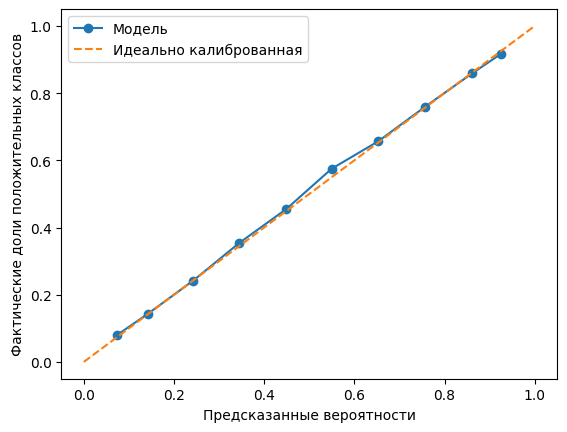

In [75]:
from sklearn.calibration import calibration_curve
y_prob = clf.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test['target'].values, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Модель')
plt.plot([0, 1], [0, 1], linestyle='--', label='Идеально калиброванная')
plt.xlabel('Предсказанные вероятности')
plt.ylabel('Фактические доли положительных классов')
plt.legend()
plt.show()

In [76]:
user_mode_pred = preds.groupby('user_id')['predict'].apply(pd.Series.mode).reset_index()

In [78]:
user_label = train_labels.set_index('user_id').loc[user_mode_pred['user_id'].values]

In [80]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(user_label['target'], user_mode_pred['predict']))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85     27095
           1       0.83      0.83      0.83     24765

    accuracy                           0.84     51860
   macro avg       0.84      0.84      0.84     51860
weighted avg       0.84      0.84      0.84     51860



In [86]:
test = pd.read_csv(r'./data/test.csv', sep=';')
test['user_agent'] = test['user_agent'].apply(ast.literal_eval)
test['domain'] = test['referer'].str.extract(r'https://([^/]+)')
test['path'] = test['referer'].str.extract(r'https://[^/]+/(.*)')
test['browser'] = test['user_agent'].str.get('browser')
test['browser_version'] = test['user_agent'].str.get('browser_version')
test['os'] = test['user_agent'].str.get('os')
test['os_version'] = test['user_agent'].str.get('os_version')

In [87]:
test = test.merge(
    referer_vectors_no_dupl.drop('referer', axis=1),
    on=['domain', 'path'],
    how='left'
)

test = test.merge(
    geo_info,
    on=['geo_id'],
    how='left'
)

test = test.merge(
    train_labels,
    on='user_id',
)

#test.fillna('', inplace=True)

In [89]:
test.isna().sum()

request_ts           0
user_id              0
referer              0
geo_id               0
user_agent           0
domain               0
path                 0
browser              0
browser_version      0
os                   0
os_version           0
component0           0
component1           0
component2           0
component3           0
component4           0
component5           0
component6           0
component7           0
component8           0
component9           0
country_id           0
region_id          768
timezone_id          0
target               0
dtype: int64